In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# import own modules
repo_name = 'indoor-localization-time-varying-environments'
module_path = os.getcwd()[:os.getcwd().find(repo_name)+len(repo_name)]
sys.path.append(os.path.abspath(module_path))

from src.data_utils import get_results_filename

In [2]:
COLUMN_WIDTH = 3.8
TEXT_WIDTH = 7.35
FONT_SIZE = 8
DPI = 400
PAD_INCHES = 0.01

plt.rcParams["font.size"] = FONT_SIZE
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

results_path = os.path.join(module_path, "results")

## Complementary CDF Plots

Text(0, 0.5, 'CCDF')

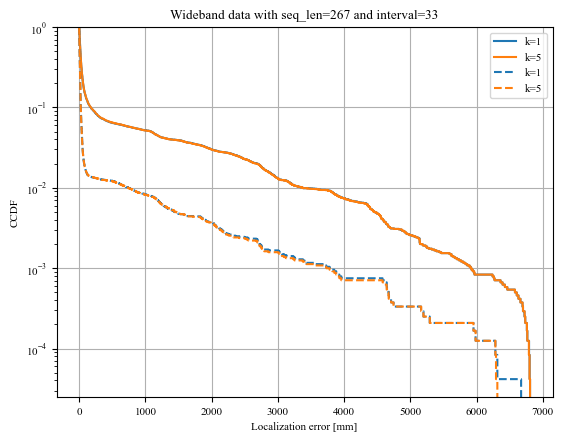

In [3]:
# Plot wideband results for different number of neighbors

seq_len = 267
interval = 33
subchannels = [1, 4]
timesteps = 1
ls_by_sc = {1: '-', 4: '--'}
neighbors = [1, 5]

for sc in subchannels:
    for k_idx, k in enumerate(neighbors):
        errors = np.load(get_results_filename(results_path, "knn", seq_len, interval, sc, timesteps, num_neighbors=k))
        errors = errors.flatten()
        plt.ecdf(np.abs(errors), complementary=True, c=f"C{k_idx}", ls=ls_by_sc[sc], label=f'k={k}')
    
plt.title(f'Wideband data with seq_len={seq_len} and interval={interval}')
plt.gca().set_yscale('log')
plt.legend()
plt.grid()
plt.xlabel("Localization error [mm]")
plt.ylabel("CCDF")

Text(0, 0.5, 'CCDF')

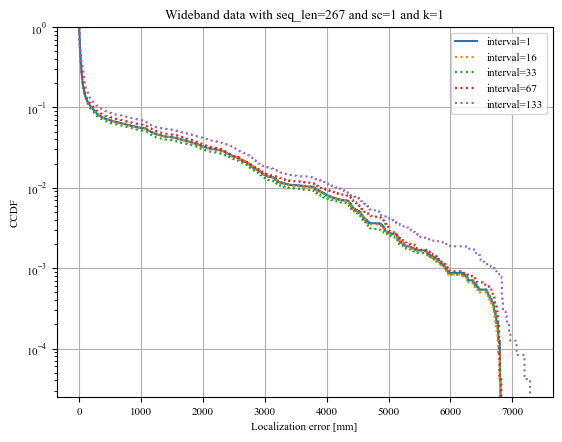

In [4]:
# Plot wideband results for different interval lengths

seq_len = 267
k = 1
subchannels = 1
timesteps = 1
intervals = [1, 16, 33, 67, 133]

for interval in intervals:
    errors = np.load(
        get_results_filename(
            results_path, "knn", seq_len, interval, subchannels, timesteps, num_neighbors=k
        )
    )
    errors = errors.flatten()

    plt.ecdf(np.abs(errors), complementary=True, ls=":" if interval > 1 else "-", label=f'interval={interval}')
    
plt.title(f'Wideband data with seq_len={seq_len} and sc={subchannels} and k={k}')
plt.gca().set_yscale('log')
plt.legend()
plt.grid()
plt.xlabel("Localization error [mm]")
plt.ylabel("CCDF")

Text(0, 0.5, 'CCDF')

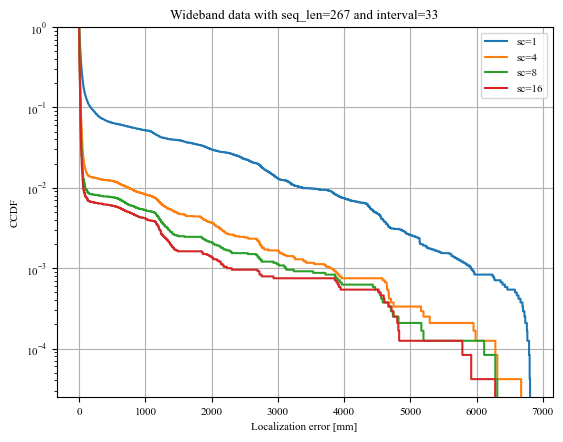

In [5]:
# Plot wideband results for different number of subchannels

seq_len = 267
interval = 33
subchannels = [1, 4, 8, 16]
k = 1
ts = 1

for sc in subchannels:
    errors = np.load(
        get_results_filename(
            results_path, "knn", seq_len, interval, sc, ts, num_neighbors=k
        )
    )
    errors = errors.flatten()

    plt.ecdf(np.abs(errors), complementary=True, label=f'sc={sc}')
    
plt.title(f'Wideband data with seq_len={seq_len} and interval={interval}')
plt.gca().set_yscale('log')
plt.legend()
plt.grid()
plt.xlabel("Localization error [mm]")
plt.ylabel("CCDF")

## Analyze Effect of Sequence Length

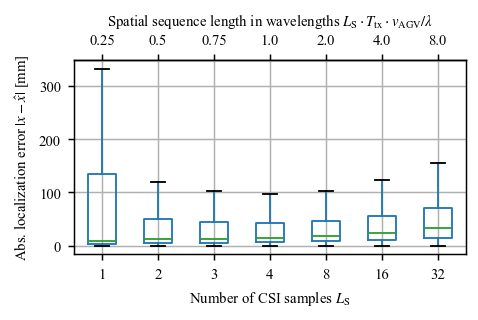

In [6]:
sequence_lengths = [33, 67, 100, 133, 267, 533, 1067]
k = 1
interval = 33
subchannels = 1
timesteps = 1

errors = {}
for seq_len in sequence_lengths:
    l = seq_len // interval
    errors[l] = np.abs(
        np.load(
            get_results_filename(
                results_path,
                "knn",
                seq_len,
                interval,
                subchannels,
                timesteps,
                num_neighbors=k,
            )
        )
    ).flatten()

# the longer the sequence length, the lower the number of actual test samples
# we need to truncate the errors to the same length for all sequence lengths
min_num_samples = min([len(errors[l]) for l in errors.keys()])
errors = {l: errors[l][:min_num_samples] for l in errors.keys()}

plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH * 1 / 2), dpi=DPI // 3)

errors_df = pd.DataFrame(errors)
errors_df.boxplot(showfliers=False)
# plt.gca().set_yscale('log')
plt.xlabel(r"Number of CSI samples $L_\text{S}$")
plt.ylabel(r"Abs. localization error $|x - \hat{x}|$ [mm]")

ax_bottom = plt.gca()
ax_top = ax_bottom.secondary_xaxis("top")
ax_top.set_xticks(ax_bottom.get_xticks(), labels=[f"{l/4}" for l in errors.keys()])
ax_top.set_xlabel(r"Spatial sequence length in wavelengths $L_\text{S} \cdot T_\text{tx} \cdot  v_\text{AGV} / \lambda$")

plt.savefig(
    os.path.join(module_path, "figures", "sequence_length_boxplot.pdf"),
    bbox_inches="tight",
    dpi=DPI,
    pad_inches=PAD_INCHES,
)


Text(0, 0.5, 'CCDF')

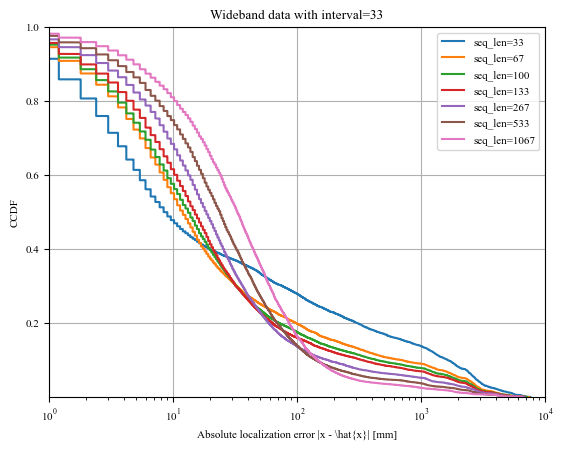

In [7]:
sequence_lengths = [33, 67, 100, 133, 267, 533, 1067]
k = 1
interval = 33
subchannels = 1

for seq_len in sequence_lengths:
    errors = np.abs(
        np.load(
            get_results_filename(
                results_path, "knn", seq_len, interval, subchannels, timesteps, num_neighbors=k
            )
        ).flatten()
    )
    errors = errors.flatten()

    plt.ecdf(np.abs(errors), complementary=True, label=f'seq_len={seq_len}')
    
plt.title(f'Wideband data with interval={interval}')
plt.gca().set_xscale('log')
plt.xlim([1e0, 1e4])
# plt.gca().set_yscale('log')
plt.ylim([1e-3, 1])
plt.legend()
plt.grid()
plt.xlabel(r"Absolute localization error |x - \hat{x}| [mm]")
plt.ylabel("CCDF")

## Compare Different Number of Subchannels

Method: knn, SC: 1, TB: 1, Percentile of 10mm: 31.59%
Method: knn, SC: 1, TB: 4, Percentile of 10mm: 89.16%
Method: knn, SC: 1, TB: 8, Percentile of 10mm: 96.52%
Method: mlp, SC: 1, TB: 1, Percentile of 10mm: 0.84%
Method: mlp, SC: 1, TB: 4, Percentile of 10mm: 1.34%
Method: mlp, SC: 1, TB: 8, Percentile of 10mm: 1.27%
Method: knn, SC: 4, TB: 1, Percentile of 10mm: 62.43%
Method: knn, SC: 4, TB: 4, Percentile of 10mm: 99.01%
Method: knn, SC: 4, TB: 8, Percentile of 10mm: 99.70%
Method: mlp, SC: 4, TB: 1, Percentile of 10mm: 1.50%
Method: mlp, SC: 4, TB: 4, Percentile of 10mm: 1.43%
Method: mlp, SC: 4, TB: 8, Percentile of 10mm: 1.31%
Method: knn, SC: 8, TB: 1, Percentile of 10mm: 71.12%
Method: knn, SC: 8, TB: 4, Percentile of 10mm: 99.52%
Method: knn, SC: 8, TB: 8, Percentile of 10mm: 99.90%
Method: mlp, SC: 8, TB: 1, Percentile of 10mm: 1.58%
Method: mlp, SC: 8, TB: 4, Percentile of 10mm: 1.39%
Method: mlp, SC: 8, TB: 8, Percentile of 10mm: 1.27%
Method: knn, SC: 16, TB: 1, Percentil

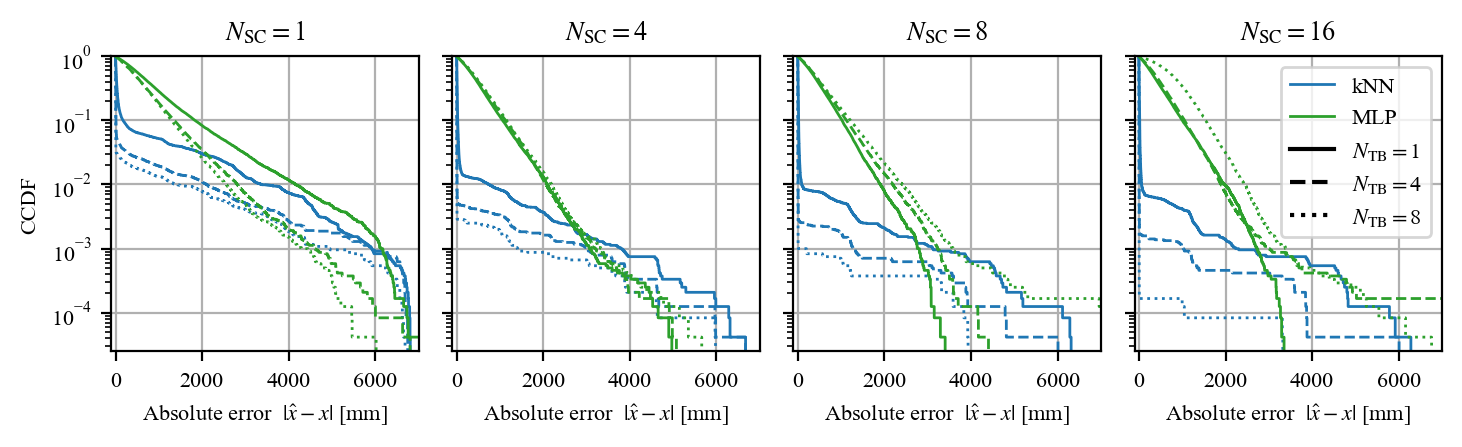

In [8]:
subchannels = [1, 4, 8, 16]
methods = ["knn", "resmlp", "mlp"]
seq_len = 267
interval = 33
timesteps = [1, 2, 4, 8]
k = 1

error_for_percentile = 10

color_by_method = {m: f"C{idx}" for idx, m in enumerate(methods)}
ls_by_timesteps = {1: "-", 2: "-.", 4: "--", 8: ":"}
method_to_method_label = {
    "knn": "kNN",
    "mlp": "MLP",
    "resmlp": "ResMLP",
}

# some lines can be skipped for better readability
methods_to_skip = ["resmlp"] #"mlp"
ts_to_skip = [2]


fig, ax = plt.subplots(
    1,
    len(subchannels),
    sharex=True,
    sharey=True,
    figsize=(TEXT_WIDTH, COLUMN_WIDTH * 3 / 5),
    dpi=DPI // 2,
)
for ax_idx, sc in enumerate(subchannels):
    for method in methods:

        if method in methods_to_skip:
            continue

        for ts in timesteps:

            if ts in ts_to_skip:
                continue

            if method == "knn":
                k_ = k
            else:
                k_ = None

            filename = get_results_filename(
                results_path,
                method,
                seq_len,
                interval,
                sc,
                ts,
                num_neighbors=k_,
            )
            try:
                errors = np.load(filename).flatten()
            except FileNotFoundError:
                print(filename)
                continue

            ax[ax_idx].ecdf(
                np.abs(errors),
                color=color_by_method[method],
                ls=ls_by_timesteps[ts],
                lw=1,
                complementary=True,
                label=method_to_method_label[method] if ts == 1 else None,
            )

            # calculate and print the percentile of the specified error
            p = np.sum(np.abs(errors) < error_for_percentile) / len(errors)
            print(
                f"Method: {method}, SC: {sc}, TB: {ts}, "
                f"Percentile of {error_for_percentile}mm: {p:.2%}"
            )

    for ts in timesteps:
        if ts in ts_to_skip:
            continue
        ax[ax_idx].plot(
            [], [], color="k", ls=ls_by_timesteps[ts], label=r"$N_\text{TB}=$" + f"{ts}"
        )

    ax[ax_idx].set_title(r"$N_\text{SC}=$" + f"{sc}")
    ax[ax_idx].set_yscale("log")
    ax[ax_idx].grid()
    ax[ax_idx].set_xlabel(r"Absolute error  $|\hat{x} - x|$ [mm]")
    if ax_idx == 0:
        ax[ax_idx].set_ylabel("CCDF")
    else:
        ax[ax_idx].set_ylabel("")
    if sc == subchannels[-1]:
        ax[ax_idx].legend(loc="upper right", fontsize=FONT_SIZE)

plt.xlim([-1e2, 7e3])

plt.tight_layout()

plt.savefig(
    os.path.join(module_path, "figures", "subchannels_and_timeblocks_evaluation.pdf"),
    bbox_inches="tight",
    pad_inches=PAD_INCHES,
)

## Neighbor Distances and Localization Error

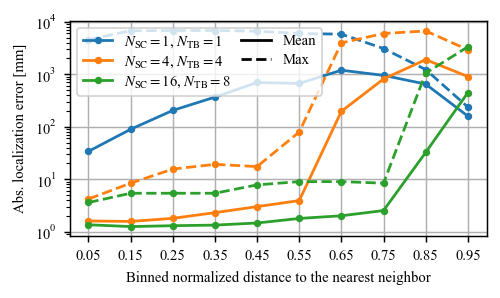

In [9]:
sequence_length = 267
interval = 33

n_bins = 10

configs = [[1, 1], [4, 4], [16, 8]]  # [num_sc, num_tb]

plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH * 3 / 5), dpi=DPI // 3)

for config_idx, config in enumerate(configs):
    subchannels = config[0]
    timesteps = config[1]

    filename = get_results_filename(
        results_path,
        "knn",
        sequence_length,
        interval,
        subchannels,
        timesteps,
        num_neighbors=1,
    )
    errors = np.abs(np.load(filename).flatten())
    distances = np.load(
        os.path.join(
            os.path.dirname(filename), "neighbor_distances", os.path.basename(filename)
        )
    ).flatten()

    distances = (distances - np.min(distances)) / (
        np.max(distances) - np.min(distances)
    )

    binned_errors = {}
    bin_width = 1 / n_bins
    bin_start = 0
    for bin_idx in range(n_bins):
        bin_end = bin_start + bin_width if bin_idx < n_bins - 1 else np.inf
        mask = (distances >= bin_start) & (distances < bin_end)
        binned_errors[bin_idx] = errors[mask]
        bin_start = bin_end

    means = [np.mean(binned_errors[bin_idx]) for bin_idx in range(n_bins)]
    maxs = [
        np.max(binned_errors[bin_idx]) if len(binned_errors[bin_idx]) > 0 else np.nan
        for bin_idx in range(n_bins)
    ]
    plt.plot(
        np.arange(n_bins) * bin_width + bin_width / 2,
        means,
        ".-",
        color=f"C{config_idx}",
        label=r"$N_\text{SC}=$"
        + str(subchannels)
        + r", $N_\text{TB}=$"
        + str(timesteps),
    )
    plt.plot(
        np.arange(n_bins) * bin_width + bin_width / 2,
        maxs,
        ".--",
        color=f"C{config_idx}",
    )

plt.plot([], [], "k-", label="Mean")
plt.plot([], [], "k--", label="Max")


plt.xticks(np.arange(n_bins) * bin_width + bin_width / 2, fontsize=FONT_SIZE)
plt.yscale("log")
plt.legend(ncols=2, columnspacing=0.7, labelspacing=0.3, loc="upper left")
plt.grid()
plt.xlabel("Binned normalized distance to the nearest neighbor")
plt.ylabel("Abs. localization error [mm]")

plt.tight_layout()
plt.savefig(
    os.path.join(module_path, "figures", "distance_to_nearest_neighbor.pdf"),
    bbox_inches="tight",
    dpi=DPI,
    pad_inches=PAD_INCHES,
)

C:\Users\Anton.Krause\AppData\Local\Temp\2\ipykernel_22668\3142390629.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(


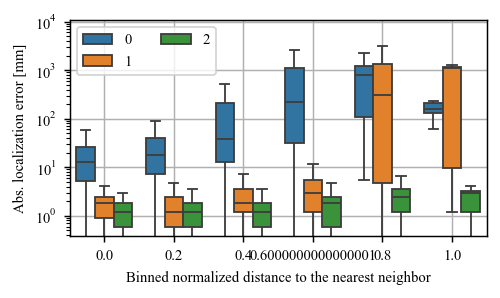

In [10]:
sequence_length = 267
interval = 33

n_bins = 5

configs = [[1, 1], [4, 4], [16, 8]]  # [num_sc, num_tb]

plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH * 3 / 5), dpi=DPI // 3)

df = pd.DataFrame(columns=["distance", "error", "config"])
bin_width = 1 / n_bins

for config_idx, config in enumerate(configs):
    subchannels = config[0]
    timesteps = config[1]

    filename = get_results_filename(
        results_path,
        "knn",
        sequence_length,
        interval,
        subchannels,
        timesteps,
        num_neighbors=1,
    )
    errors = np.abs(np.load(filename).flatten())
    distances = np.load(
        os.path.join(
            os.path.dirname(filename), "neighbor_distances", os.path.basename(filename)
        )
    ).flatten()


    distances = (distances-np.min(distances)) / (np.max(distances) - np.min(distances))
    distances = np.round(distances / bin_width) * bin_width

    df = pd.concat([df, pd.DataFrame(
        {"distance": distances, "error": errors, "config": config_idx}
    )])


sns.boxplot(
    x="distance",
    y="error",
    data=df,
    hue="config",
    palette="tab10",
    fliersize=0,
)

plt.yscale('log')
plt.legend(ncols=2, loc="upper left")
plt.grid()
plt.xlabel("Binned normalized distance to the nearest neighbor")
plt.ylabel("Abs. localization error [mm]")

plt.tight_layout()
plt.savefig(
    os.path.join(module_path, "figures", "distance_to_nearest_neighbor_boxplot.pdf"),
    bbox_inches="tight",
    dpi=DPI,
    pad_inches=PAD_INCHES,
)